In [1]:
import torch
import time
import numpy as np
from PIL import Image

In [2]:
class Conv_BN_Prelu(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups):
        super(Conv_BN_Prelu, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.prelu = torch.nn.PReLU(out_channels)
        
    def forward(self, inp):
        inp = self.conv(inp)
        inp = self.bn(inp)
        inp = self.prelu(inp)
        return inp

class Conv_Prelu(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups):
        super(Conv_Prelu, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
        self.prelu = torch.nn.PReLU(out_channels)
    
    def forward(self, inp):
        inp = self.conv(inp)
        inp = self.prelu(inp)
        return inp
    
class ResBlock(torch.nn.Module):
    def __init__(self, in_channels, kernel_size, stride, padding, groups):
        super(ResBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
        self.bn1 = torch.nn.BatchNorm2d(in_channels)
        self.prelu1 = torch.nn.PReLU(in_channels)
        self.conv2 = torch.nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
        self.bn2 = torch.nn.BatchNorm2d(in_channels)
        self.prelu2 = torch.nn.PReLU(in_channels)
        
    def forward(self, inp):
        x = self.conv1(inp)
        x = self.bn1(inp)
        x = self.prelu1(inp)
        x = self.conv2(inp)
        x = self.bn2(inp)
        x = self.prelu2(inp)
        
        inp = inp + x
        return inp
    
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.start = Conv_Prelu(in_channels=3, out_channels=64, kernel_size=9, stride=1, padding=4, groups=1)
        self.res1 = ResBlock(in_channels=64, kernel_size=3, stride=1, padding=1, groups=1)
        self.res2 = ResBlock(in_channels=64, kernel_size=3, stride=1, padding=1, groups=1)
        self.res3 = ResBlock(in_channels=64, kernel_size=3, stride=1, padding=1, groups=1)
        self.res4 = ResBlock(in_channels=64, kernel_size=3, stride=1, padding=1, groups=1)
        self.res5 = ResBlock(in_channels=64, kernel_size=3, stride=1, padding=1, groups=1)
        
        self.block = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, groups=1),
                    torch.nn.BatchNorm2d(64))
        
        self.upsample_bolck1 = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, groups=1),
                    torch.nn.BatchNorm2d(256),
                    torch.nn.PixelShuffle(upscale_factor=2)
        )
        
        self.upsample_bolck2 = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, groups=1),
                    torch.nn.BatchNorm2d(256),
                    torch.nn.PixelShuffle(upscale_factor=2)
        )
        
        self.final_conv = torch.nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, stride=1, padding=1, groups=1)
        
    def forward(self, inp):
        x = self.start(inp)
        res1_x = self.res1(x)
        res2_x = self.res2(res1_x)
        res3_x = self.res3(res2_x)
        res4_x = self.res4(res3_x)
        res5_x = self.res5(res4_x)
        
        block = self.block(res5_x)
        block = res5_x + block
        
        out = self.upsample_bolck1(block)
        out = self.upsample_bolck2(out)
        
        out = self.final_conv(out)
        return out
        
        

In [3]:
model = Generator()
model.eval()
print("DONE")

DONE


In [4]:
tt = 0
for i in range(10):
    inp = torch.ones(1,3,96,96)
    st = time.time()
    model.forward(inp)
    tt += time.time() - st
print(tt/10)

0.6758743524551392


In [5]:
inp = (torch.rand(96*96*3).view(1,3,96,96) * 255.0).numpy().astype(np.uint8)

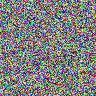

In [6]:
Image.fromarray(np.transpose(inp, (0,2,3,1))[0])

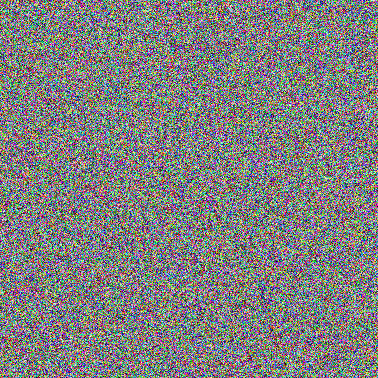

In [7]:
Image.fromarray(model.forward(torch.FloatTensor(inp)).permute(0,2,3,1).detach().numpy()[0].astype(np.uint8))